In [1]:
import lobi as lb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2 as cv
import os
import serial
from tqdm import tqdm
import schunk

## Messung
- [Index](index.ipynb)

Hier werden alle Parameter und Informationen für den Datensatz übergeben.    
- `Messung` Name des Dateiordners. Bsp.: Zylinder P(0.5,0)
- `Elektroden` Anzahl der messenden Elektroden [16,32]. Dementsprechend wir 'd' oder 'e' an das SpectraEIT-Kit gesendet.
- `SchunkStep` Schrittweite zwischen den Messungen
- `Leitwert` gemessen mit Leitwertmessgerät
- `Temperatur` Raumtemperatur
- `Wasserstand` Wasserstand ist die Variable für die höhe der eingefüllten Flüssigkeit
- `Sonstiges` Weitere Informationen können vorab über dieses Feld hinzugefügt werden. Diese Variable wird über die gesamte Messdatenaufnahme nicht mehr aufgerufen.
- `Objekt` Umfasst die in dem Messbereich eingefügten Messobjekte. Muss bei der `ground_truth` Funktion selbst neu eingefügt werden.

In [2]:
#Globale Angaben einer Messreihe
Messung     = 'Zylinder P(0.5,0)_k' # Dateiordnername
Elektroden  = 16                  # Anzahl der Elektroden
SchunkStep  = 15                   #[grad/Schritt]
Leitwert    = 1                   # Leitfähigkeit Wasser
Temperatur  = 20                  # Raumtemperatur [°C]
Wasserstand = 33                  # Wasserstand [mm]
Sonstiges   = 'Flüssigkeit:Kochsalzlösung'
Objekt      = 'Quader'
Anzahl      = 2                  #Anzahl der aufzunehmenden Messwerte

In [3]:
#SchrittArray für Schunk Drehteller:
GRAD = np.arange(0,361,SchunkStep)
GRAD

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360])

In [4]:
lb.gen_env(Messung,Elektroden,SchunkStep,Leitwert,Temperatur, Wasserstand, Sonstiges)

Ordner mit dem Namen:" Zylinder P(0.5,0)_k " wurde erstellt.


## Herstellen Verbindung Schunk

In [5]:
mod = schunk.Module(schunk.SerialConnection(0x0B, serial.Serial, port='COM3', baudrate=9600, timeout=1))

## Herstellen der Verbindung zum Spectra EIT-Kit

In [6]:
#serialPort = lb.init("COM7")
serialPort = lb.init("COM4")

Verbindung zu: COM4 erfolgreich hergestellt.


## Testen Schunk

In [23]:
angles=np.arange(0,361,90) #(0,361,90)
angles
for angle in angles:
    mod.move_pos(angle)
    mod.wait_until_position_reached()
    print(angle)
mod.move_pos(0)

0
90
180
270
360


24.256122589111328

In [7]:
mod.move_pos(0)

24.256345748901367

## Ground truth
Es müssen Arrays übergeben werden. Grundsätzlich müssen die Anzahl der in den Arrays enthaltenen Elementen identisch sein.
- `['rectangle','circle','triangle']` Auswahl eines oder mehrerer gleicher oder unterschiedlicher Elemente
- `[r]` Abstand des Gegenstandes vom Mittelpunkt in Prozent ($r[\%] = \sqrt{x^2+y^2}\cdot 100$)
- `[α]` Winkel bezogen auf die $x$-Achse des Gegenstandes. Drehrichtung ist abhängig von `clockdirection`
- `Dir` Verzeichnes in dem das Groundtruth Bild gespeichert werden soll.

optional:
- `clockdirection` Drehung um den Winkel α _in_ oder _gegen_ der Uhrzeigersinn
- `save_img` default `save_img = True`

Bild gespeichert


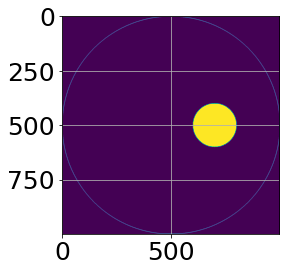

In [8]:
#Kartesische Eingabe
P_x_y = [0.5,0]
R = lb.CarCirc(P_x_y)
#Manuelle prozentuale Eingabe:
#R = [100]
img1 = lb.ground_truth(['circle'],R,[0*np.pi], Messung ,save_img=True)
plt.grid()
plt.imshow(img1,cmap='viridis')

## Mittelwert ohne Probe aufnehmen
- Beachten, dass keine Probe in der Messumgebung ist

In [10]:
Mean = []
Anzahl_mean = 2
try:
    print('Messung des Mittelwertbildes')    
    Mean = lb.measure_data(Anzahl_mean,serialPort,M=192)#896
except:
    Mean = []
    print('Bitte erneut ausführen')
Mean = np.mean(Mean,0)

Messung des Mittelwertbildes
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Vorgang:  2 von:  2


In [11]:
# Mittelwert speichern:
np.save(str(Messung)+'/'+'Mean_empty_ground', Mean)
Mean = np.load(str(Messung)+'/Mean_empty_ground.npy')

### Messung für `Anzahl` an Werten starten
- `GRAD` ... Winkelschritte in °.
- `grad` ... wird auf den aktuellen Drehwinkel des Drehtellers gesetzt.
- Wenn die `Data` leer ist, wird die Iteration von `grad` neu gestartet.
- `try` wird zur verhinderung von nicht vollständigen Messungen verwendet.

In [12]:
print('Fortschritt der Winkelschritte:')
pbar = tqdm(total = len(GRAD))
check = 0
Data = []
while check < len(GRAD):
    grad = GRAD[check]
    #--- Schunk Teller auf Position drehen ---
    mod.move_pos(grad)
    mod.wait_until_position_reached()
    #---
    try:
        print('Messung des '+ str(grad) + '° Schritt')    
        Data = lb.measure_data(Anzahl,serialPort)
        lb.export_xlsx(Data,Messung,Mean,grad)
        check +=1
    except:
        Data = []
        print('Neustart. Daten sind nicht vollständig...')
pbar.close()

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Fortschritt der Winkelschritte:
Messung des 0° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Vorgang:  2 von:  2
Messung 0 erfolgreich exportiert
Messung des 15° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 15 erfolgreich exportiert
Messung des 30° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 30 erfolgreich exportiert
Messung des 45° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 45 erfolgreich exportiert
Messung des 60° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 60 erfolgreich exportiert
Messung des 75° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 75 erfolgreich exportiert
Messung des 90° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 90 erfolgreich exportiert
Messung des 105° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 105 erfolgreich exportiert
Messung des 120° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2
Messung 120 erfolgreich exportiert
Messung des 135° Schritt
Vorgang:  1 von:  2
Vorgang:  2 von:  2

  0%|                                                                                           | 0/25 [06:28<?, ?it/s]

Messung 360 erfolgreich exportiert


## [Rekonstruktion](Reconstruction.ipynb)